In [1]:
import jax
from jax import grad, jit, lax, random, vmap
from jax.experimental.ode import odeint
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
#import relative_fitness_gp
from ode_models import two_variant_model, three_variant_model

## Exponential growth -> Relative fitness -> Frequency

In [3]:
# Simulate two-variant SIR

## Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type

gen_wt = 1.8 # Average length of infection (days): 1 / gam_wt
eta_T = 1.5 # Transmissibility increase
eta_E = 0.7 * eta_T # Escape fraction 

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

In [4]:
#####  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E)

# Simulate first wave with no variants
# S0, I_wt, I_ve, I_vt, R_wt, R_ve, Inc_wt, Inc_ve, Inc_vt
u01 = jnp.array([0.999, 
                 0.0001, 0.0, 0.0, 
                 0.0, 0.0, 0.0,
                 0.0, 0.0, 0.0])
t1 = jnp.arange(20.)
Y1 = odeint(three_variant_model, u01, t1, true_θ)

# Simulate second wave with transmissibility variant
u02 = Y1[-1, :].at[3].add(1e-5)
t2 = jnp.arange(50.) + t1[-1] + 1
Y2 = odeint(three_variant_model, u02, t2, true_θ)

# Simulate third wave with escape variant
u03 = Y2[-1, :].at[2].add(1e-6)
t3 = jnp.arange(50.) + t2[-1] + 1
Y3 = odeint(three_variant_model, u03, t3, true_θ)

# Combine outputs and unpack
t = jnp.concatenate((t1, t2, t3))
Y = jnp.concatenate((Y1, Y2[1:,:], Y3[1:,:]), axis=0)

S, I_wt, I_ve,  I_vt = Y[:,0], Y[:, 1], Y[:, 2], Y[:, 3]
phi_wt, phi_ve, phi_vt  = Y[:, 4], Y[:, 5], Y[:,6]
Inc_wt, Inc_ve, Inc_vt = Y[:, 7], Y[:, 8], Y[:, 9]

In [9]:
PRES_PATH = "../../HHMI_poster/figures/"

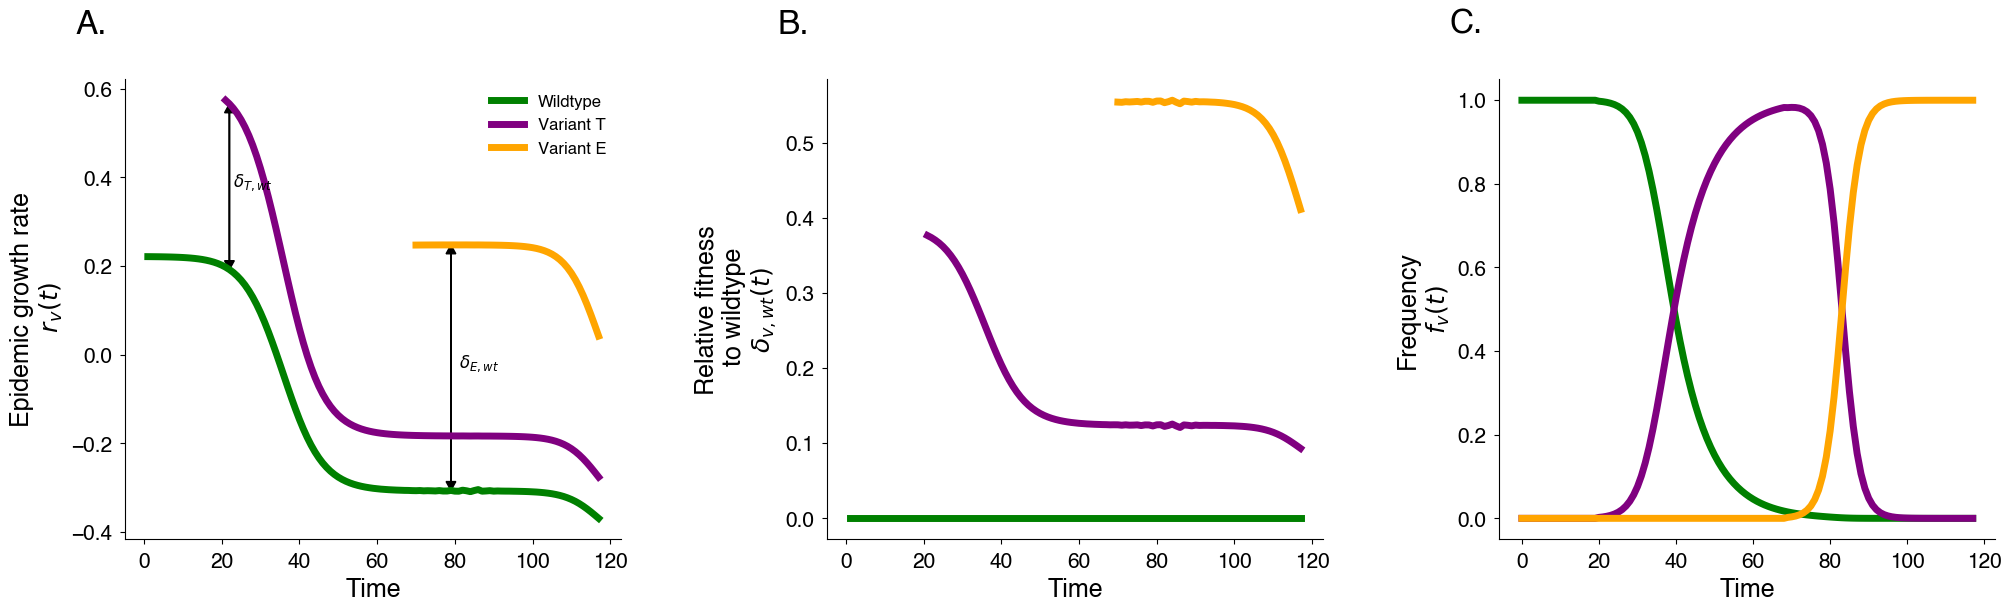

In [51]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(20., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1, wspace=0.1)

# Plotting prevalence
#ax_prev = fig.add_subplot(spec[0, 0])
#ax_prev.plot(I_wt, color=WT_COLOR, label=WT_LABEL)
#ax_prev.plot(I_vt, color=VART_COLOR, label=VART_LABEL)
#ax_prev.plot(I_ve, color=VARE_COLOR, label=VARE_LABEL)

#ax_prev.set_ylabel("Prevalence")
#ax_prev.legend(frameon=False)

# Plotting epidemic growth rate
def egr(Y):
    return jnp.diff(jnp.log(Y), prepend=jnp.nan)
    
ax_egr = fig.add_subplot(spec[0])
ax_egr.plot(egr(I_wt), color=WT_COLOR, label=WT_LABEL)
ax_egr.plot(egr(I_vt), color=VART_COLOR,  label=VART_LABEL)
ax_egr.plot(egr(I_ve), color=VARE_COLOR, label=VARE_LABEL)
ax_egr.set_ylabel("Epidemic growth rate\n " + r"$r_{v}(t)$")
ax_egr.set_xlabel("Time")
ax_egr.legend(frameon=False)

## Adding arrows
def add_arrows(ax, t, y1, y2, label, text_offset, horizontalalignment="left"):
    arrow_style = {
        "head_width": 2.5,
        "head_length": 0.02,
        "color":"k"
    }
    ax_egr.arrow(t, y1, dx=0, dy=y2-y1, **arrow_style, length_includes_head=True)
    ax_egr.arrow(t, y2, dx=0, dy=y1-y2, **arrow_style, length_includes_head=True)

    ax_egr.annotate(
        xy=(t, y1), 
        xytext=(t+text_offset, (y1+y2)/2),
        text=label,
        horizontalalignment=horizontalalignment)
    
annotate_t1, annotate_t2 = int(t1[-1]+3), int(t2[-1] + 10)
egr_wt, egr_vt, egr_ve = egr(I_wt), egr(I_vt), egr(I_ve)

add_arrows(ax_egr, annotate_t1, egr_wt[annotate_t1], egr_vt[annotate_t1], r"$\delta_{T,wt}$", text_offset=1)
add_arrows(ax_egr, annotate_t2, egr_wt[annotate_t2], egr_ve[annotate_t2], r"$\delta_{E,wt}$", text_offset=2)

# Frequency
ax_freq = fig.add_subplot(spec[2])
ax_freq.plot(I_wt / (I_wt + I_vt + I_ve), color=WT_COLOR, label=WT_LABEL)
ax_freq.plot(I_vt / (I_wt + I_vt + I_ve), color=VART_COLOR, label=VART_LABEL)
ax_freq.plot(I_ve / (I_wt + I_vt + I_ve), color=VARE_COLOR, label=VARE_LABEL)
ax_freq.set_ylabel("Frequency\n" + r"$f_{v}(t)$")
ax_freq.set_xlabel("Time")

# Relative fitness
delta_wt = egr_wt - egr_wt
delta_ve = egr_ve - egr_wt
delta_vt = egr_vt - egr_wt

ax_relfit = fig.add_subplot(spec[1])
ax_relfit.plot(delta_wt, color=WT_COLOR, label=WT_LABEL)
ax_relfit.plot(delta_vt, color=VART_COLOR, label=VART_LABEL)
ax_relfit.plot(delta_ve, color=VARE_COLOR, label=VARE_LABEL)

ax_relfit.set_ylabel("Relative fitness\n to wildtype\n" + r"$\delta_{v,wt}(t)$")
ax_relfit.set_xlabel("Time")

# Add in immune pools
#ax_immune = fig.add_subplot(spec[2, 0])
#ax_immune.plot(S, color="red", label="Naive")
#ax_immune.plot(phi_wt, color=WT_COLOR, label=WT_LABEL)
#ax_immune.plot(phi_vt, color=VART_COLOR, label=VART_LABEL)
#ax_immune.plot(phi_ve, color=VARE_COLOR, label=VARE_LABEL)
#ax_immune.set_ylabel("Immune pools")
#ax_immune.legend(frameon=False)

# Add in Rt
#ax_rt = fig.add_subplot(spec[2, -1])
#ax_rt.plot(beta_wt * S / gam_wt, color=WT_COLOR, label=WT_LABEL)
#ax_rt.plot(beta_wt * eta_T * S  / gam_wt, color=VART_COLOR, label=VART_LABEL)
#ax_rt.plot(beta_wt * eta_T * (eta_E * phi_wt + eta_E * phi_wt  + S) / gam_wt, color=VARE_COLOR, label=VARE_LABEL)
#TODO: Hide before variant introduced... Same for prev and frequency
#ax_rt.set_ylabel("Effective reproduction\n number")

import string
axes = [ax_egr, ax_relfit, ax_freq]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')
    
#TODO: Compute EGR by hand
#TODO: Comparing futures for variants with differnt properties at same starting point!

#Comment: Panel C things rise at similar point in time (?). 
    # How to highlight that different mechanim is explaining this difference?
    
fig.savefig(PRES_PATH + "methods_variant_frequencies/growth_rates_to_frequencies.png")

## Transmissibility-Escape trade-off

In [56]:
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Transmissibility variant", "Escape variant"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

In [57]:
# Getting base parameters
R0 = 2.8
gamma = 1 / 3.2
beta = R0 * gamma
beta

0.875

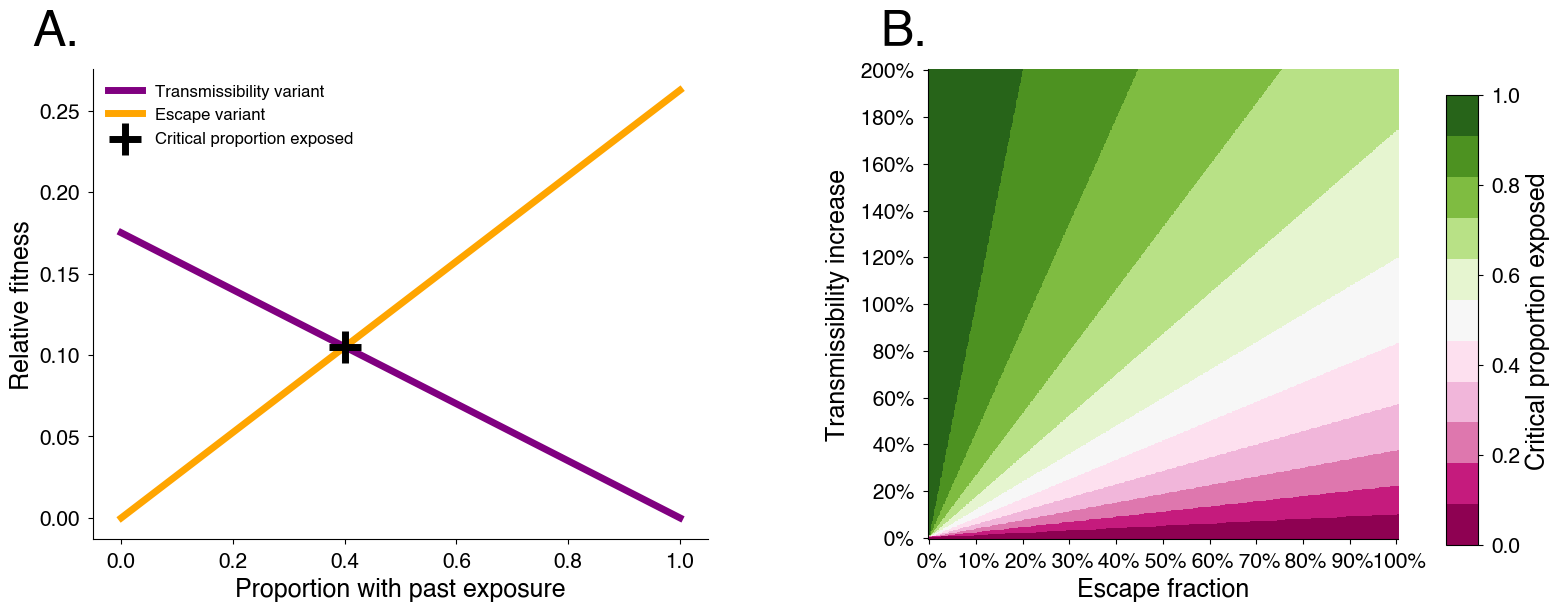

In [74]:
# Set up axes
fig = plt.figure(figsize=(16., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[0.7, 1.0])

# A. Proportion vaccinated on x-axis, relative fitness at y.
# Show when immune escape is preferred

### Panel A parameters
eta_E = 0.3
eta_T = 1.2
prop_exposed = np.linspace(0,1,31)
###

ax = fig.add_subplot(spec[0])
var_t_lambda = (eta_T - 1) * beta * (1 - prop_exposed)
var_e_lambda = eta_E * beta * prop_exposed
ax.plot(prop_exposed, var_t_lambda, color = VART_COLOR, label = VART_LABEL)
ax.plot(prop_exposed, var_e_lambda, color = VARE_COLOR, label = VARE_LABEL)
ax.set_xlabel("Proportion with past exposure")
ax.set_ylabel("Relative fitness")

# Highlight point of intersection
def critical_proportion(eta_T, eta_E):
    return (eta_T - 1) / (eta_E + eta_T-1)

crit_prop = critical_proportion(eta_T, eta_E)
crit_relfit = eta_E * beta * crit_prop
ax.scatter(crit_prop, crit_relfit , s=500, color="k", marker="+", zorder=3, label="Critical proportion exposed")
ax.legend(frameon=False)

ax_panel_a = ax

# B. Point of vaccination where escape preferred various eta_E and eta_T
ax = fig.add_subplot(spec[:, 1])

eta_T = np.linspace(3.00, 1.0, 161)
eta_E = np.linspace(0.001, 0.996, 161)

eta_Emg, eta_Tmg = np.meshgrid(eta_E, eta_T)

crit_props = critical_proportion(eta_Tmg, eta_Emg)
cmap = plt.get_cmap('PiYG',11)
im = ax.imshow(crit_props, vmin=0, vmax=1, cmap=cmap)
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.75])
fig.colorbar(im, cbar_ax, label = "Critical proportion exposed")
yticks = [*range(len(eta_T))][::16]
xticks = [*range(len(eta_E))][::16]

ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xticklabels([f"{eta_E[v]: .2f}" for v in xticks])
ax.set_yticklabels([f"{eta_T[v]: .2f}" for v in yticks])

ax.set_xticklabels([f"{eta_E[v]: .0%}" for v in xticks])
ax.set_yticklabels([f"{(eta_T[v] -1): .0%}" for v in yticks])

ax.set_ylabel("Transmissibility increase")
ax.set_xlabel("Escape fraction")
ax_panel_b = ax


# Add panel labels
import string
axes = [ax_panel_a, ax_panel_b]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

In [75]:
fig_te_tradeoff = fig
fig_te_tradeoff.savefig(PRES_PATH + "transmission_mechanisms/" + "transmission_tradeoff.png", bbox_inches='tight')